# Модель предсказания спроса 

## Сбор данных

Нам необходимо собрать данные, которые могут характеризовать изменения спроса за неделю до его прогноза. Вот, что нам точно будет нужно:
* данные о спросе за неделю до прогноза
* прогнозируемые бронирования за неделю до прогноза - на неделе? 
    * в каждый из дней - сколько бронирований, у скольких прогноз +, сколько человек (из тех, кто приехал/приедет) уедут
* данные о спросе год назад в эту дату
* изменение спроса в этот день недели за два месяца?
* данные о дате - день, месяц, год, день недели, номер недели

И все это надо будет собрать для двух отелей

In [679]:
# !pip install hypopt

You should consider upgrading via the '/Users/katyona/Desktop/University/proga/iad/notebooks/bin/python3 -m pip install --upgrade pip' command.


In [803]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pickle

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import roc_auc_score, roc_curve, fbeta_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

from data_preprocessing import *

import folium
from folium.plugins import HeatMap
import plotly.express as px

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.size'] = 12
sns.set(style="darkgrid")
plt.rcParams['axes.prop_cycle'] = plt.style.library['bmh']['axes.prop_cycle']

In [546]:
city_or = pd.read_csv('city_or.csv').rename(columns={'Unnamed: 0': 'date'})
resort_or = pd.read_csv('resort_or.csv').rename(columns={'Unnamed: 0': 'date'})
occupancy_rate = pd.read_csv('occupancy_rate.csv').rename(columns={'Unnamed: 0': 'date'})

data_train = pd.read_csv('data_train.csv')

In [548]:
date_of_arrival = pd.to_datetime(
    data_train['arrival_date_year'].astype(str)  + \
    data_train['arrival_date_month'] + \
    data_train['arrival_date_day_of_month'].astype(str), 
    format='%Y%B%d'
)

data_train['arrival_date'] = date_of_arrival.dt.date

In [654]:
data_train['checkout_date'] = data_train['arrival_date'] + \
pd.to_timedelta((data_train['stays_in_week_nights'] + data_train['stays_in_weekend_nights']), unit='d')
data_train['people_total'] = data_train['adults'] + data_train['children'] + data_train['babies']

data_train['booking_date'] = data_train['arrival_date'] - pd.to_timedelta(data_train['lead_time'], unit='d')

/Users/katyona/Desktop/University/proga/iad/notebooks/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


In [550]:
city_or['date'] = pd.to_datetime(city_or['date']).dt.date
resort_or['date'] = pd.to_datetime(resort_or['date']).dt.date
occupancy_rate['date'] = pd.to_datetime(occupancy_rate['date']).dt.date

ТУТ НАДО БУДЕТ ВСТАВИТЬ ВЕСЬ АНАЛИЗ ДАННЫХ 

## Обзор данных и создание нового датасета

`data_train` - это очищенный датасет с бронированиями в двух отелях. Из изначального датасета в результате очистки были удалены несоответствия и пустые значения, а также нерелевантные для обуечния и рассмотрения данные, которые мы заново добавили для удобства в самом начале этой тетрадки

In [551]:
data_train.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'arrival_date', 'checkout_date',
       'people_total'],
      dtype='object')

Чтобы обучить модель на достоверных данных, то есть с реальными предсказаниями отмен, необходимо будет поделить всю выборку на несколько частей:
1. Часть выборки, на которой будет обучаться модель предсказания отмены бронирований
2. Часть выборки, на которой будет обучаться модель предсказания спроса
3. Часть выборки, на которой будет происходить валидация модели предсказания спроса
4. Тестовая часть для проверки работоспособности модели предсказания спроса

Можно поделить выборку пополам.
На более ранней половине обучить модель прогнозирования отмены, а более позднюю половину разбить на треин, валидацию и тест

In [552]:
date_of_arrival.quantile(0.5, interpolation="midpoint")

Timestamp('2016-09-07 00:00:00')

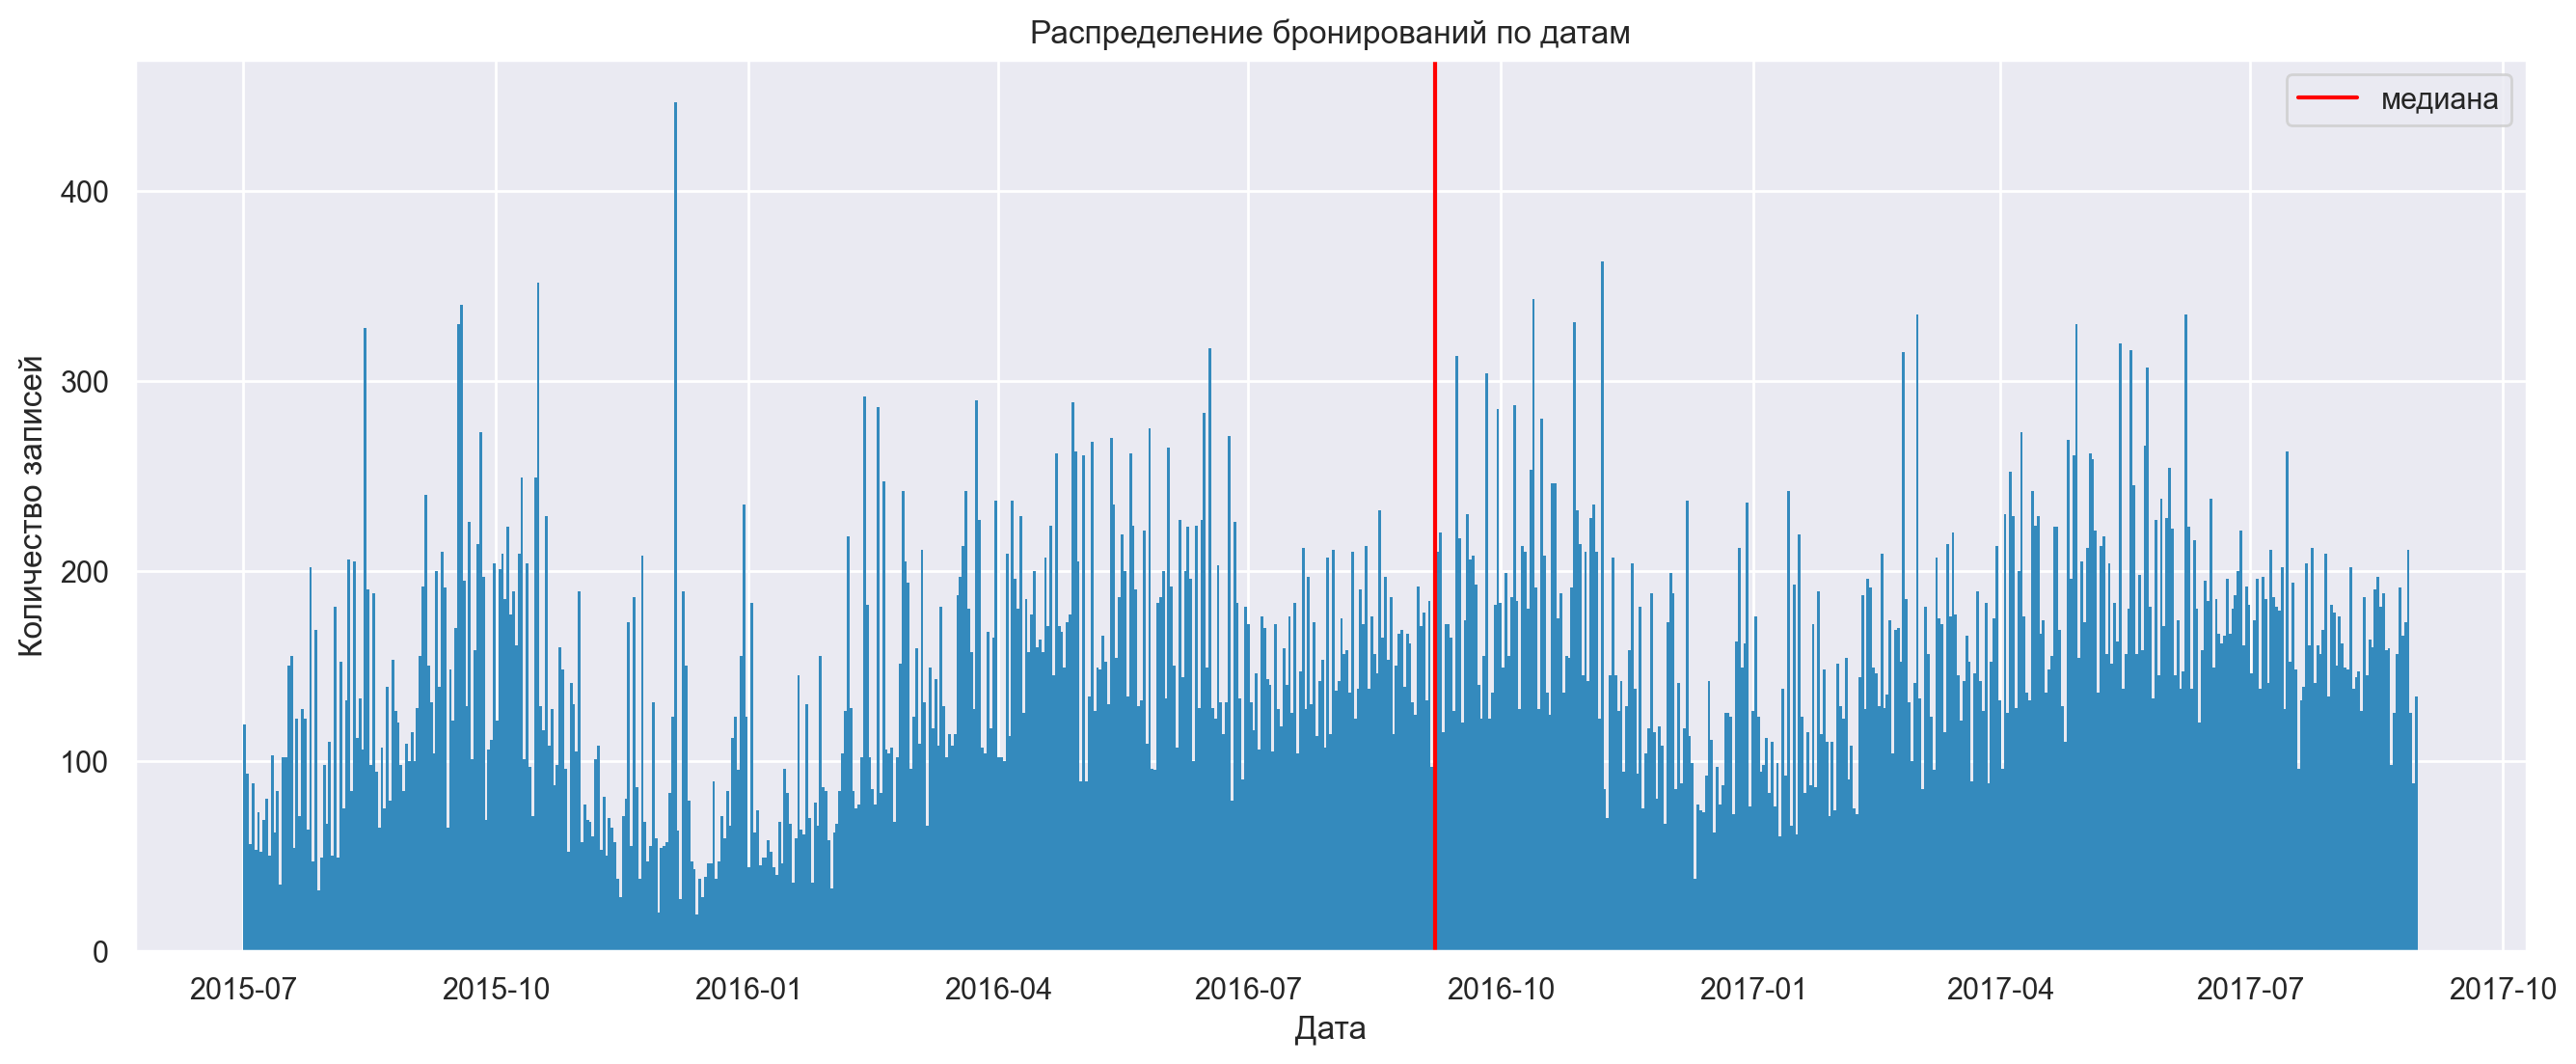

In [298]:
plt.figure(figsize=(16, 6))

plt.hist(date_of_arrival, bins=date_of_arrival.nunique(), lw=0)
plt.axvline(x=date_of_arrival.quantile(0.5, interpolation="midpoint"), color='red', label='медиана')

plt.legend(loc='upper right')
plt.xlabel('Дата')
plt.ylabel('Количество записей')
plt.title('Распределение бронирований по датам')

plt.show()

In [486]:
date_of_arrival[date_of_arrival < date_of_arrival.quantile(0.5, interpolation="midpoint")].shape

(59254,)

In [553]:
data_canc = data_train[date_of_arrival < date_of_arrival.quantile(0.5, interpolation="midpoint")]

In [554]:
data_demand = data_train[date_of_arrival >= date_of_arrival.quantile(0.5, interpolation="midpoint")]

In [555]:
datad_prpr = preprocess(data_demand, cat_encoding='OHE', delete_columns=False)

scaler = StandardScaler()
scaler.fit(datad_prpr)
datad_prpr = scaler.transform(datad_prpr)

In [37]:
# model = pickle.load(open('random_forest_model.sav', 'rb'))

model.fit(datad_prpr, data_demand['is_canceled'])


RandomForestClassifier(n_estimators=300)

In [38]:
cross_val_score(model, datad_prpr, data_demand['is_canceled'], cv=5, scoring='accuracy')

array([0.66014505, 0.49295775, 0.45399342, 0.58438053, 0.71459897])

Если обучать модель на слишком маленькой выборке, то доля верных ответов получится неудовлетворительной. Значит, попробуем сделать "финт ушами" - будем генерировать правильность ответа с вероятностью, равной доле верных ответов. Это позволит нам использовать правильные ответы, но с заданной вероятностью они буду становиться неправильными

In [556]:
data_train[data_train['is_canceled'] == 1].shape

(44176, 30)

In [557]:
filter1 = np.random.choice([1, 0], data_train[data_train['is_canceled'] == 1].shape[0], p=[1 - 0.76, 0.76])
filter0 = np.random.choice([1, 0], data_train[data_train['is_canceled'] == 0].shape[0], p=[1 - 0.93, 0.93])

In [558]:
cancellations = data_train['is_canceled'].values.copy()
index1 = 0
index0 = 0

for i in range(cancellations.shape[0]):
    if cancellations[i] == 0:
        cancellations[i] += filter0[index0]
        index0 += 1
    elif cancellations[i] == 1:
        cancellations[i] -= filter1[index1]
        index1 += 1
    

In [559]:
data_train['predicted_cancellations'] = cancellations

In [834]:
data_train[(data_train['predicted_cancellations'] == 1) & (data_train['is_canceled'] == 1)].shape[0] / data_train.shape[0]

0.28350767673359206

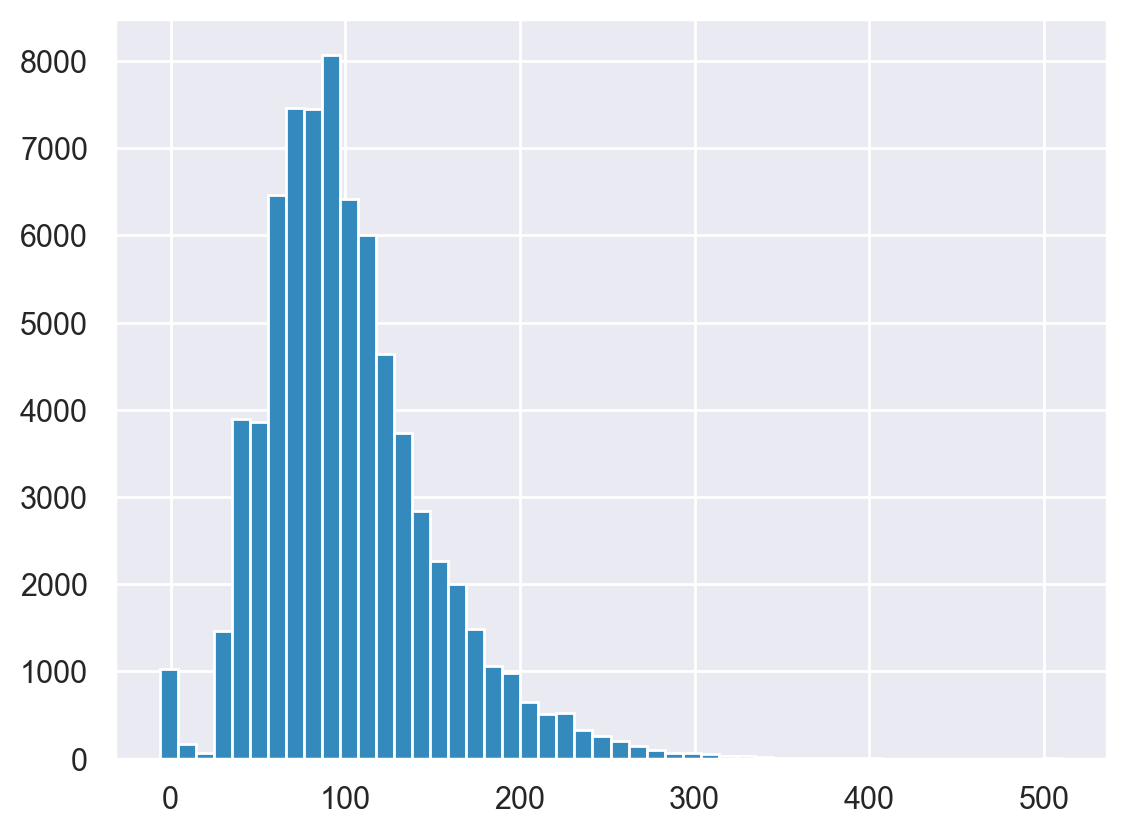

In [839]:
plt.hist(data_train[data_train['is_canceled'] == 0]['adr'], bins=50)
plt.show()

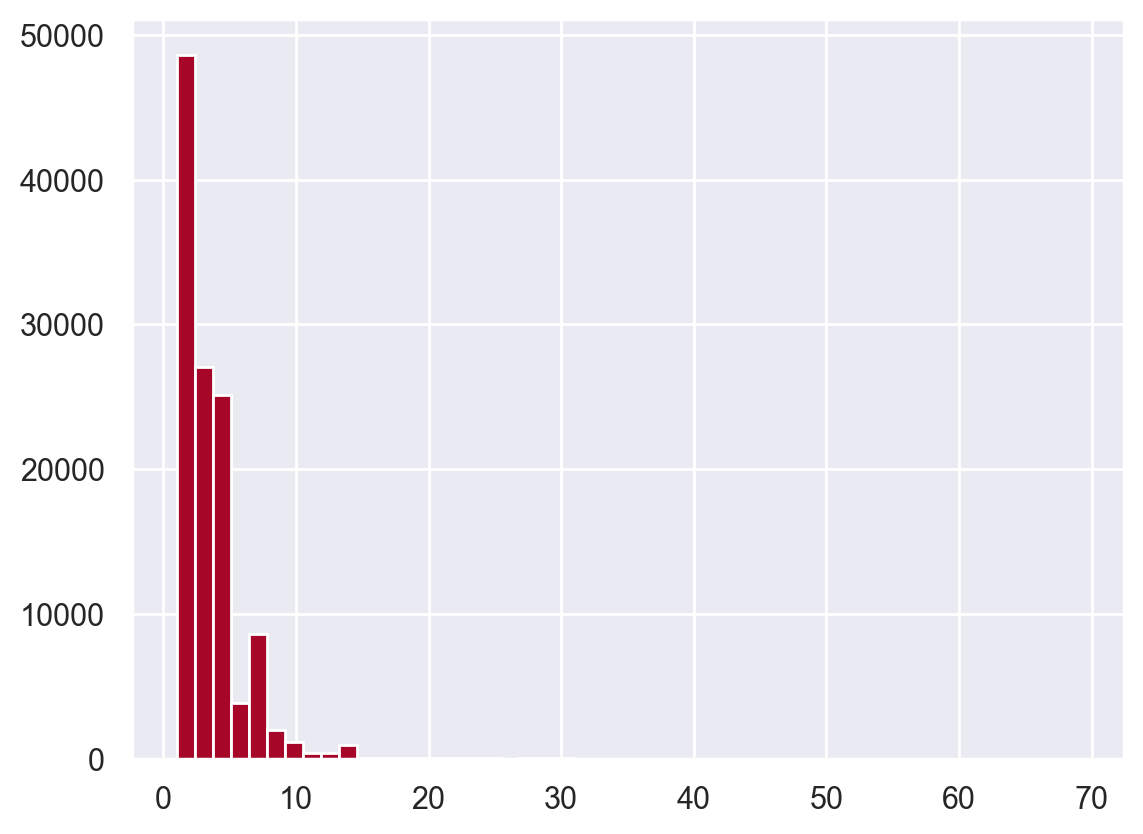

In [843]:
plt.hist((data_train['stays_in_weekend_nights'] + data_train['stays_in_week_nights']).values, bins=50)
plt.show()

In [847]:
(data_train['stays_in_weekend_nights'] + data_train['stays_in_week_nights']).mean()

3.4440273325459763

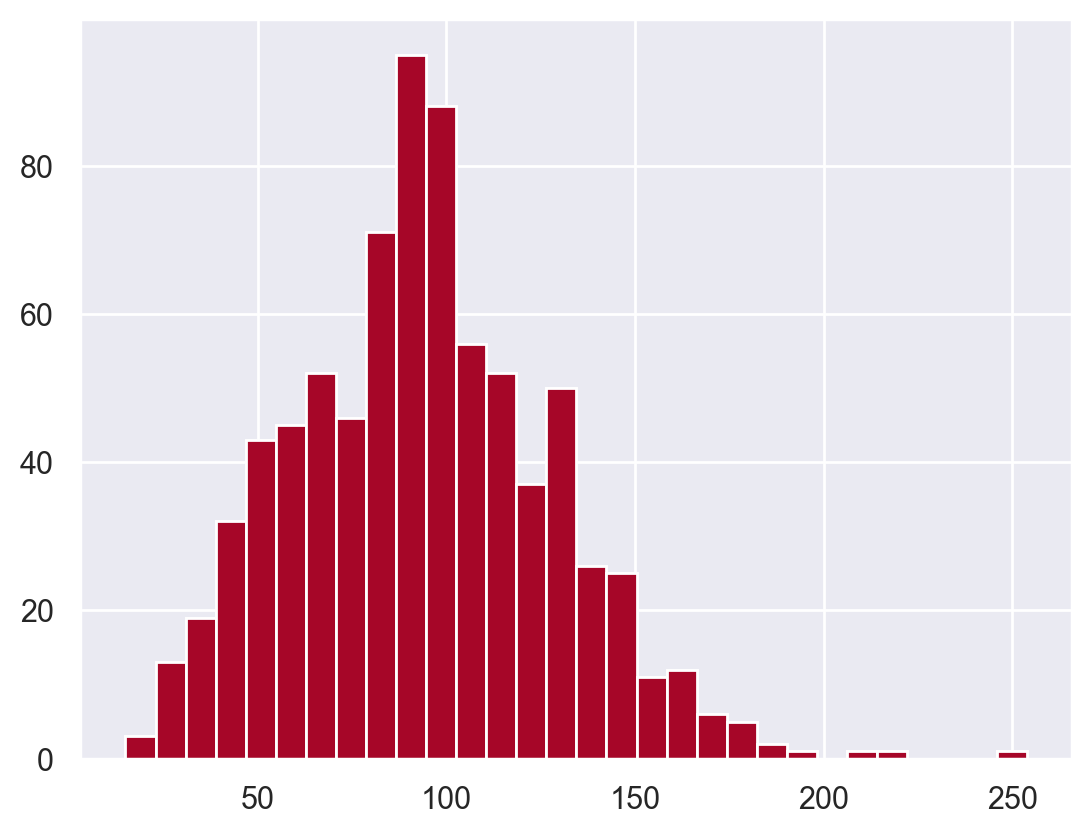

In [854]:
plt.hist(data_train[data_train['is_canceled'] == 0].groupby('arrival_date')['arrival_date'].count().values, bins=30)
plt.show()

Для сегодняшней даты мне надо собрать:
* сколько сейчас гостей
* сколько бронирований на каждый из 7 дней
* сколько из бронирований подтверждаются на каждый из 7 дней
* сколько выездов планируется на каждый из 7 дней
* сколько было гостей в эту дату год назад
* сколько было неделю назад
* месяц
* год
* день недели
* номер дня
* номер недели
* ВСЕ ЭТО ДЛЯ ДВУХ ОТЕЛЕЙ

In [560]:
columns=['or_1yrbefore',
         'or_2wbefore', 
         'year', 
         'month', 
         'day',
         'day_of_week',
         'week_of_year']

columns += [f'book_approved_{n}dbefore' for n in range(8)]
columns += [f'bookings_{n}dbefore' for n in range(8)]
columns += [f'checkouts_{n}dbefore' for n in range(8)]

df_demand_city = pd.DataFrame(columns=columns)
df_demand_resort = pd.DataFrame(columns=columns)

In [561]:
data_train['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [562]:
filter_canc0 = (data_train['is_canceled'] == 0)
filter_resort = (data_train['hotel'] == 'Resort Hotel')
filter_city = (data_train['hotel'] == 'City Hotel')

In [563]:
df_demand_resort['date'] = resort_or['date'][resort_or['date'] <= \
                                         data_train[filter_canc0 & filter_resort]['arrival_date'].max()]


df_demand_city['date'] = city_or['date'][city_or['date'] <= \
                                         data_train[filter_canc0 & filter_city]['arrival_date'].max()]

df_demand_resort.shape, df_demand_city.shape

((793, 32), (793, 32))

In [564]:
or_arrivals_city = city_or[city_or['date'] <= df_demand_city['date'].max()]
or_arrivals_city = or_arrivals_city.set_index('date')

or_arrivals_city = or_arrivals_city.loc[df_demand_city['date']]
df_demand_city['target'] = or_arrivals_city['occupancy_rate'].values

df_demand_city = df_demand_city.set_index('date')

In [565]:
or_arrivals_resort = resort_or[resort_or['date'] <= df_demand_resort['date'].max()]
or_arrivals_resort = or_arrivals_resort.set_index('date')

or_arrivals_resort = or_arrivals_resort.loc[df_demand_resort['date']]
df_demand_resort['target'] = or_arrivals_resort['occupancy_rate'].values

df_demand_resort = df_demand_resort.set_index('date')

Сначала сопоставим значения `occupancy rate` год назад

In [566]:
cor_1yrbefore = city_or[['date', 'occupancy_rate']][city_or['date'] + \
                                                          pd.Timedelta(days=365) <= df_demand_city.index.max()]

cor_1yrbefore['date'] = cor_1yrbefore['date'] + pd.Timedelta(days=365)

df_demand_city.loc[cor_1yrbefore['date'], 'or_1yrbefore'] = cor_1yrbefore['occupancy_rate'].values

In [567]:
ror_1yrbefore = resort_or[['date', 'occupancy_rate']][resort_or['date'] + \
                                                          pd.Timedelta(days=365) <= df_demand_resort.index.max()]

ror_1yrbefore['date'] = ror_1yrbefore['date'] + pd.Timedelta(days=365)

df_demand_resort.loc[ror_1yrbefore['date'], 'or_1yrbefore'] = ror_1yrbefore['occupancy_rate'].values

Затем две недели назад от даты прогнозирования

In [568]:
cor_2wbefore = city_or[['date', 'occupancy_rate']][city_or['date'] + \
                                                          pd.Timedelta(days=14) <= df_demand_city.index.max()]

cor_2wbefore['date'] = cor_2wbefore['date'] + pd.Timedelta(days=14)

df_demand_city.loc[cor_2wbefore['date'], 'or_2wbefore'] = cor_2wbefore['occupancy_rate'].values

In [569]:
ror_2wbefore = resort_or[['date', 'occupancy_rate']][resort_or['date'] + \
                                                          pd.Timedelta(days=14) <= df_demand_resort.index.max()]

ror_2wbefore['date'] = ror_2wbefore['date'] + pd.Timedelta(days=14)

df_demand_resort.loc[ror_2wbefore['date'], 'or_2wbefore'] = ror_2wbefore['occupancy_rate'].values

Теперь сопоставим даты

In [570]:
df_demand_city['year'] = pd.DatetimeIndex(df_demand_city.index).year
df_demand_city['month'] = pd.DatetimeIndex(df_demand_city.index).month
df_demand_city['day'] = pd.DatetimeIndex(df_demand_city.index).day
df_demand_city['day_of_week'] = pd.DatetimeIndex(df_demand_city.index).weekday
df_demand_city['week_of_year'] = pd.to_datetime(df_demand_city.index).isocalendar().week

df_demand_resort['year'] = pd.DatetimeIndex(df_demand_resort.index).year
df_demand_resort['month'] = pd.DatetimeIndex(df_demand_resort.index).month
df_demand_resort['day'] = pd.DatetimeIndex(df_demand_resort.index).day
df_demand_resort['day_of_week'] = pd.DatetimeIndex(df_demand_resort.index).weekday
df_demand_resort['week_of_year'] = pd.to_datetime(df_demand_resort.index).isocalendar().week

In [571]:
filter_preds = (data_train['predicted_cancellations'] == 0)

In [573]:
c_bookings_on_date = data_train[filter_city].groupby('arrival_date')['people_total'].sum()
c_bookings_approved_on_date = data_train[filter_preds & filter_city].groupby('arrival_date')['people_total'].sum()
c_chouts_approved_on_date = data_train[filter_preds & filter_city].groupby('checkout_date')['people_total'].sum()

c_chouts_approved_on_date = c_chouts_approved_on_date[c_chouts_approved_on_date.index <= \
                                                      df_demand_city.index.max()]
c_chouts_approved_on_date[df_demand_city.index.min()] = 0
c_chouts_approved_on_date = c_chouts_approved_on_date.sort_index()


r_bookings_on_date = data_train[filter_resort].groupby('arrival_date')['people_total'].sum()
r_bookings_approved_on_date = data_train[filter_preds & filter_resort].groupby('arrival_date')['people_total'].sum()
r_chouts_approved_on_date = data_train[filter_preds & filter_resort].groupby('checkout_date')['people_total'].sum()

r_chouts_approved_on_date = r_chouts_approved_on_date[r_chouts_approved_on_date.index <= \
                                                      df_demand_resort.index.max()]
r_chouts_approved_on_date[df_demand_resort.index.min()] = 0
r_chouts_approved_on_date = r_chouts_approved_on_date.sort_index()

In [574]:
df_demand_city['book_approved_0dbefore'] = c_bookings_approved_on_date
df_demand_city['bookings_0dbefore'] = c_bookings_on_date
df_demand_city['checkouts_0dbefore'] = c_chouts_approved_on_date

df_demand_resort['book_approved_0dbefore'] = r_bookings_approved_on_date
df_demand_resort['bookings_0dbefore'] = r_bookings_on_date
df_demand_resort['checkouts_0dbefore'] = r_chouts_approved_on_date

In [575]:
c_bookings_on_date = c_bookings_on_date.reset_index().rename(columns={'arrival_date': 'date'})
c_bookings_approved_on_date = c_bookings_approved_on_date.reset_index().rename(columns={'arrival_date': 'date'})
c_chouts_approved_on_date = c_chouts_approved_on_date.reset_index().rename(columns={'checkout_date': 'date'})

r_bookings_on_date = r_bookings_on_date.reset_index().rename(columns={'arrival_date': 'date'})
r_bookings_approved_on_date = r_bookings_approved_on_date.reset_index().rename(columns={'arrival_date': 'date'})
r_chouts_approved_on_date = r_chouts_approved_on_date.reset_index().rename(columns={'checkout_date': 'date'})

In [576]:
delta = pd.to_timedelta(1, unit='days')

for i in range(1, 8):
    
    # for city hotel
    c_bookings_on_date['date'] = c_bookings_on_date['date'] + delta
    c_bookings_approved_on_date['date'] = c_bookings_approved_on_date['date'] + delta
    c_chouts_approved_on_date['date'] = c_chouts_approved_on_date['date'] + delta
    
    c_bookings_on_date = c_bookings_on_date[c_bookings_on_date['date'] <= df_demand_city.index.max()]
    c_bookings_approved_on_date = c_bookings_approved_on_date[c_bookings_approved_on_date['date'] <= \
                                                          df_demand_city.index.max()]
    c_chouts_approved_on_date = c_chouts_approved_on_date[c_chouts_approved_on_date['date'] <= \
                                                          df_demand_city.index.max()]
    
    
    df_demand_city.loc[c_bookings_on_date['date'], f'bookings_{i}dbefore'] = \
    c_bookings_on_date['people_total'].values
    df_demand_city.loc[c_bookings_approved_on_date['date'], f'book_approved_{i}dbefore'] = \
    c_bookings_approved_on_date['people_total'].values
    df_demand_city.loc[c_chouts_approved_on_date['date'], f'checkouts_{i}dbefore'] = \
    c_chouts_approved_on_date['people_total'].values
    
    
    # for resort hotel
    r_bookings_on_date['date'] = r_bookings_on_date['date'] + delta
    r_bookings_approved_on_date['date'] = r_bookings_approved_on_date['date'] + delta
    r_chouts_approved_on_date['date'] = r_chouts_approved_on_date['date'] + delta
    
    r_bookings_on_date = r_bookings_on_date[r_bookings_on_date['date'] <= df_demand_resort.index.max()]
    r_bookings_approved_on_date = r_bookings_approved_on_date[r_bookings_approved_on_date['date'] <= \
                                                          df_demand_resort.index.max()]
    r_chouts_approved_on_date = r_chouts_approved_on_date[r_chouts_approved_on_date['date'] <= \
                                                          df_demand_resort.index.max()]
    
    
    df_demand_resort.loc[r_bookings_on_date['date'], f'bookings_{i}dbefore'] = \
    r_bookings_on_date['people_total'].values
    df_demand_resort.loc[r_bookings_approved_on_date['date'], f'book_approved_{i}dbefore'] = \
    r_bookings_approved_on_date['people_total'].values
    df_demand_resort.loc[r_chouts_approved_on_date['date'], f'checkouts_{i}dbefore'] = \
    r_chouts_approved_on_date['people_total'].values

In [578]:
# df_demand_city = df_demand_city.loc[pd.to_datetime('2015-07-08').date():, :]
# df_demand_resort = df_demand_resort.loc[pd.to_datetime('2015-07-08').date():, :]

In [596]:
df_demand_city['hotel'] = pd.Series([1] * df_demand_city.shape[0]).values
df_demand_resort['hotel'] = pd.Series([0] * df_demand_resort.shape[0]).values

In [609]:
# df_demand_city = df_demand_city.reset_index()
# df_demand_resort = df_demand_resort.reset_index()

df_demand = pd.concat([df_demand_city, df_demand_resort], axis=0, ignore_index=True)

In [610]:
df_demand = df_demand.sort_values(by='date').reset_index(drop=True)

In [857]:
df_demand.columns

Index(['date', 'or_1yrbefore', 'or_2wbefore', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'book_approved_0dbefore',
       'book_approved_1dbefore', 'book_approved_2dbefore',
       'book_approved_3dbefore', 'book_approved_4dbefore',
       'book_approved_5dbefore', 'book_approved_6dbefore',
       'book_approved_7dbefore', 'bookings_0dbefore', 'bookings_1dbefore',
       'bookings_2dbefore', 'bookings_3dbefore', 'bookings_4dbefore',
       'bookings_5dbefore', 'bookings_6dbefore', 'bookings_7dbefore',
       'checkouts_0dbefore', 'checkouts_1dbefore', 'checkouts_2dbefore',
       'checkouts_3dbefore', 'checkouts_4dbefore', 'checkouts_5dbefore',
       'checkouts_6dbefore', 'checkouts_7dbefore', 'target', 'hotel'],
      dtype='object')

## Анализ полученных данных 

## Пробное моделирование

Важно не перемешивать данные, так как предсказания строятся для будущих данных на основании прошлых данных. Это значит, что если более поздняя запись попадет в обучающую выборку, то закономерность нарушится, так как такой ситуации при решении реальной бизнес-задачи возникнуть не может. На таких задачах также не рекомендуется использовать кросс-валидацию

Обучать будем на тренировочной выборке (`X_train1`), а проверять качество работы модели на валидационной выборке (`X_val`). Таким образом мы подберем наилучшую модель и гиперпараметры к ней на валидационной выборке, чтобы потом протестировать результаты на тестовой - так мы полностью исключим тестовую выборку из процесса обучения.

In [778]:
X_train, X_test, y_train, y_test = train_test_split(df_demand.drop(columns=['target', 'date']),
                                                    df_demand['target'],
                                                    shuffle=False,
                                                    test_size=0.2
                                                   )

X_train1, X_val, y_train1, y_val = train_test_split(X_train,
                                                    y_train,
                                                    shuffle=False,
                                                    test_size=0.2
                                                   )

При заполнении пустых значений медианами в тренировочной выборке так же необходимо "не заглядывать в будущее" - то есть не использовать тестовую или валидационную выборку. А вот при заполнении пустых значений на валидации или тесте тренировочными данными уже можно пользоваться.

In [779]:
# X_train = np.where(np.isnan(X_train), np.median(X_train, axis=0), X_train)
# X_test = np.where(np.isnan(X_test), np.median(X_train, axis=0), X_test)

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(df_demand.drop(columns=['target', 'date']).median())

X_train1 = X_train1.fillna(X_train1.median())
X_val = X_val.fillna(X_train.median())

In [780]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_val = scaler.transform(X_val)

In [781]:
test_fold = np.array([0] * X_train.shape[0])
test_fold[:X_train1.shape[0]] = -1
ps = PredefinedSplit(test_fold)

In [782]:
lr = LinearRegression()
lr.fit(X_train1, y_train1)
lr_preds = lr.predict(X_val)

print(mean_squared_error(y_train1, lr.predict(X_train1), squared=False))
print(mean_squared_error(y_val, lr_preds, squared=False))
print(mean_absolute_percentage_error(y_train1, lr.predict(X_train1)))
print(mean_absolute_percentage_error(y_val, lr_preds))

47.99513136559347
54.63953216693987
0.21481313953129103
0.2063356872088786


In [783]:
parameters_lr = {
    'alpha': np.logspace(-2, 0, 7)
}

searcher_lr = GridSearchCV(Ridge(), 
                           parameters_lr,
                           scoring='neg_mean_absolute_percentage_error',
                           cv=ps)

searcher_lr.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Ridge(),
             param_grid={'alpha': array([0.01      , 0.02154435, 0.04641589, 0.1       , 0.21544347,
       0.46415888, 1.        ])},
             scoring='neg_mean_absolute_percentage_error')

In [784]:
searcher_lr.best_score_, searcher_lr.best_params_

(-0.18926071754743407, {'alpha': 0.01})

In [810]:
ridge = Ridge(**searcher_lr.best_params_)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

print(f'RMSE_train = {mean_squared_error(y_train, ridge.predict(X_train), squared=False)}')
print(f'RMSE_test = {mean_squared_error(y_test, ridge_preds, squared=False)}\n')

print(f'MAE_train = {mean_absolute_error(y_train, ridge.predict(X_train))}')
print(f'MAE_test = {mean_absolute_error(y_test, ridge_preds)}\n')

print(f'MAPE_train = {mean_absolute_percentage_error(y_train, ridge.predict(X_train))}')
print(f'MAPE_test = {mean_absolute_percentage_error(y_test, ridge_preds)}')

RMSE_train = 47.66829275621321
RMSE_test = 36.49782284049492

MAE_train = 38.558747590626524
MAE_test = 30.383513458801776

MAPE_train = 0.20191898660852034
MAPE_test = 0.0753789691306655


In [788]:
parameters_lasso = {
    'alpha': np.logspace(-2, 0, 7)
}

searcher_lasso = GridSearchCV(Lasso(), 
                           parameters_lasso,
                           scoring='neg_mean_absolute_percentage_error',
                           cv=ps)

searcher_lasso.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Lasso(),
             param_grid={'alpha': array([0.01      , 0.02154435, 0.04641589, 0.1       , 0.21544347,
       0.46415888, 1.        ])},
             scoring='neg_mean_absolute_percentage_error')

In [800]:
searcher_lasso.best_score_, searcher_lasso.best_params_

(-0.18937811347379108, {'alpha': 0.01})

In [791]:
parameters_dtr = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

searcher_dtr = GridSearchCV(DecisionTreeRegressor(), 
                            parameters_dtr,
                            scoring='neg_mean_absolute_percentage_error',
                            cv=ps)

searcher_dtr.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_absolute_percentage_error')

In [792]:
searcher_dtr.best_params_, searcher_dtr.best_score_

({'criterion': 'squared_error',
  'min_samples_leaf': 10,
  'min_samples_split': 2},
 -0.2647131517889223)

In [811]:
dtr = DecisionTreeRegressor(**searcher_dtr.best_params_)
dtr.fit(X_train, y_train)
dtr_preds = dtr.predict(X_test)

print(f'RMSE_train = {mean_squared_error(y_train, dtr.predict(X_train), squared=False)}')
print(f'RMSE_test = {mean_squared_error(y_test, dtr_preds, squared=False)}\n')

print(f'MAE_train = {mean_absolute_error(y_train, dtr.predict(X_train))}')
print(f'MAE_test = {mean_absolute_error(y_test, dtr_preds)}\n')

print(f'MAPE_train = {mean_absolute_percentage_error(y_train, dtr.predict(X_train))}')
print(f'MAPE_test = {mean_absolute_percentage_error(y_test, dtr_preds)}')

RMSE_train = 40.897429353238856
RMSE_test = 47.98644301160587

MAE_train = 29.207166457608132
MAE_test = 37.14083938972336

MAPE_train = 0.17387701395040273
MAPE_test = 0.0938179137415783


In [766]:
parameters_rf = {
    'n_estimators': range(100, 1001, 100),
    'max_depth': [None, 3, 5, 7], 
    'min_samples_split': [1, 3, 10]
}

searcher_rf = GridSearchCV(RandomForestRegressor(), 
                           parameters_rf,
                           scoring='neg_mean_absolute_percentage_error',
                           cv=ps)

searcher_rf.fit(X_train, y_train)

/Users/katyona/Desktop/University/proga/iad/notebooks/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/katyona/Desktop/University/proga/iad/notebooks/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/katyona/Desktop/University/proga/iad/notebooks/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 442, in fit
    trees = Parallel(
  File "/Users/katyona/Desktop/University/proga/iad/notebooks/lib/python

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 3, 5, 7],
                         'min_samples_split': [1, 3, 10],
                         'n_estimators': range(100, 1001, 100)},
             scoring='neg_mean_absolute_percentage_error')

In [767]:
searcher_rf.best_score_, searcher_rf.best_params_

(-0.20092780282072006,
 {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300})

In [812]:
rf_full = RandomForestRegressor(**searcher_rf.best_params_)
rf_full.fit(X_train, y_train)
rf_preds = rf_full.predict(X_test)

print(f'RMSE_train = {mean_squared_error(y_train, rf_full.predict(X_train), squared=False)}')
print(f'RMSE_test = {mean_squared_error(y_test, rf_preds, squared=False)}\n')

print(f'MAE_train = {mean_absolute_error(y_train, rf_full.predict(X_train))}')
print(f'MAE_test = {mean_absolute_error(y_test, rf_preds)}\n')

print(f'MAPE_train = {mean_absolute_percentage_error(y_train, rf_full.predict(X_train))}')
print(f'MAPE_test = {mean_absolute_percentage_error(y_test, rf_preds)}')

RMSE_train = 17.1004932216896
RMSE_test = 33.12820971198449

MAE_train = 12.606155744856222
MAE_test = 24.939736130007564

MAPE_train = 0.07899178122731784
MAPE_test = 0.0625762176289907


In [667]:
xgb = XGBRegressor(booster='dart', 
                   learning_rate=0.08,
                   n_estimators=1000,
                   objective='reg:linear'
                  )

xgb.fit(X_train1, y_train1)
xgb_preds = xgb.predict(X_val)

print(mean_squared_error(y_train1, xgb.predict(X_train1), squared=False))
print(mean_squared_error(y_val, xgb_preds, squared=False))

print(mean_absolute_percentage_error(y_train1, xgb.predict(X_train1)))
print(mean_absolute_percentage_error(y_val, xgb_preds))

4.126206654494945
47.125778559276974
0.01216974563205408
0.15771530539179587


In [813]:
xgb = XGBRegressor(booster='dart', 
                   learning_rate=0.1,
                   n_estimators=1000,
                   objective='reg:linear'
                  )

xgb.fit(X_train1, y_train1, eval_metric='rmse', eval_set=[(X_val, y_val)], verbose=200)
xgb_preds = xgb.predict(X_test)

print(mean_squared_error(y_train, xgb.predict(X_train), squared=False))
print(mean_squared_error(y_test, xgb_preds, squared=False))

print(mean_absolute_percentage_error(y_train, xgb.predict(X_train)))
print(mean_absolute_percentage_error(y_test, xgb_preds))

[0]	validation_0-rmse:254.642
[200]	validation_0-rmse:51.7955
[400]	validation_0-rmse:48.2174
[600]	validation_0-rmse:47.1354
[800]	validation_0-rmse:46.6656
[999]	validation_0-rmse:46.4727
25.456447468984255
32.7235161591769
0.0747790555655464
0.06686428707929672


In [796]:
parameters_xgb = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'learning_rate': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5],
    'n_estimators': [100, 300, 600, 1000],
    'objective': ['reg:linear']
}

searcher_xgb = GridSearchCV(
    XGBRegressor(),
    parameters_xgb,
    scoring='neg_mean_absolute_percentage_error',
    cv=ps
)

searcher_xgb.fit(X_train, y_train)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBRegressor(),
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'learning_rate': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5],
                         'n_estimators': [100, 300, 600, 1000],
                         'objective': ['reg:linear']},
             scoring='neg_mean_absolute_percentage_error')

In [814]:
searcher_xgb.best_score_, searcher_xgb.best_params_

(-0.15925607882579987,
 {'booster': 'gbtree',
  'learning_rate': 0.08,
  'n_estimators': 1000,
  'objective': 'reg:linear'})

In [858]:
xgb = XGBRegressor(**searcher_xgb.best_params_)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print(f'RMSE_train = {mean_squared_error(y_train, xgb.predict(X_train), squared=False)}')
print(f'RMSE_test = {mean_squared_error(y_test, xgb_preds, squared=False)}\n')

print(f'MAE_train = {mean_absolute_error(y_train, xgb.predict(X_train))}')
print(f'MAE_test = {mean_absolute_error(y_test, xgb_preds)}\n')

print(f'MAPE_train = {mean_absolute_percentage_error(y_train, xgb.predict(X_train))}')
print(f'MAPE_test = {mean_absolute_percentage_error(y_test, xgb_preds)}')

RMSE_train = 6.154332811182027
RMSE_test = 30.298756909371342

MAE_train = 4.6014253620885155
MAE_test = 24.173510015578497

MAPE_train = 0.01893596955808781
MAPE_test = 0.06227161727585863


In [859]:
pickle.dump(xgb, open('demand_prediction.sav', 'wb'))

In [730]:
xgb_grid = xgb_grid.append({'n_estimators': 1, 
                            'learning_rate': 2, 
                            'mape': 3}, ignore_index=True)

In [736]:
xgb_grid = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'mape'])

count = 0
for n_est in range(100, 1001, 100):
    for lr in [0.01, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.5]:
        count += 1
        model = XGBRegressor(booster='dart', 
                             objective='reg:linear',
                             n_estimators=n_est,
                             learning_rate=lr
                            )
        model.fit(X_train1, y_train1)
        preds = model.predict(X_val)
        mape = mean_absolute_percentage_error(preds, y_val)
        xgb_grid = xgb_grid.append({'n_estimators': n_est, 
                                    'learning_rate': lr, 
                                    'mape': mape}, ignore_index=True)
        if count % 10 == 0:
            print(f'{count} done')

10 done
20 done
30 done
40 done
50 done
60 done
70 done
80 done


In [794]:
xgb_grid[xgb_grid['mape'] == xgb_grid['mape'].min()]

,n_estimators,learning_rate,mape
76,1000.0,0.1,0.146247


In [669]:
df_demand.columns

Index(['date', 'or_1yrbefore', 'or_2wbefore', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'book_approved_0dbefore',
       'book_approved_1dbefore', 'book_approved_2dbefore',
       'book_approved_3dbefore', 'book_approved_4dbefore',
       'book_approved_5dbefore', 'book_approved_6dbefore',
       'book_approved_7dbefore', 'bookings_0dbefore', 'bookings_1dbefore',
       'bookings_2dbefore', 'bookings_3dbefore', 'bookings_4dbefore',
       'bookings_5dbefore', 'bookings_6dbefore', 'bookings_7dbefore',
       'checkouts_0dbefore', 'checkouts_1dbefore', 'checkouts_2dbefore',
       'checkouts_3dbefore', 'checkouts_4dbefore', 'checkouts_5dbefore',
       'checkouts_6dbefore', 'checkouts_7dbefore', 'target', 'hotel'],
      dtype='object')